In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['text.usetex'] = True
# sns.set_style("whitegrid")
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [9]:
def q_logarithm(input, q):
    '''q-logarithm is undefined for negative input'''
    input[input < 0] = np.nan
    if q == 1:
        return np.log(input)
    else:
        return (input ** (q-1)  - 1) / (q-1)

def q_exponential(input, q):
    if q == 1:
        return np.exp(input)
    else:
        return np.power(np.maximum(1 + (q - 1) * input, 0), 1/(q-1))
    

In [68]:
def sparsemax_operator(input, q):
    kq = 0.5*q
    dim = 0
    # number of dimmension (logits) for sparsemax distribution
    number_of_logits = input.shape[dim]

    # sort the vector in descending order, zs is the naming in the paper (Martins 2016) 
    zs = np.sort(input)[::-1]

    # range is for computation 1 + k * z > sum zj
    range = np.arange(start=1, stop=number_of_logits+1, step=1, dtype=input.dtype).reshape(1, -1)
    # range = np.broadcast_to(range, zs.shape)

    bound = kq + range * (zs - kq + kq/(q-1))

    cumulative_sum_zs = np.cumsum(zs, dim)

    # k is the cardinality of the set of allowable actions, see Eq. (4) of sparsemax (Martins 2016)
    is_greater = np.greater(bound, cumulative_sum_zs)
    k = np.maximum(np.max(is_greater * range), 1)

    # threshold function
    zs_sparse = is_greater * zs

    tau = (np.sum(zs_sparse) - kq) / k + (kq - kq/(q-1))
    expanded_tau = np.broadcast_to(tau, input.shape)

    policy = np.maximum(np.zeros_like(input), input-expanded_tau) ** (1 / (q-1))

    return policy, tau


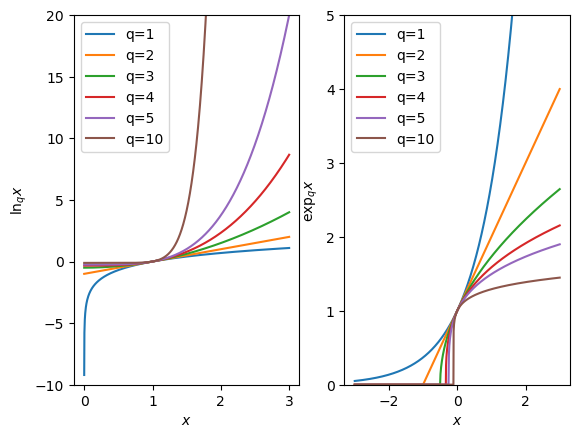

In [20]:
# illustrate q-statistics behavior
q = list(range(1, 6)) + [10]
x1 = np.linspace(-3, 3, 1000)
x2 = np.linspace(0.0001, 3, 1000)

fig, axes = plt.subplots(1, 2)
for ent_idx in q:
    expq_y = q_exponential(x1, ent_idx)
    lnq_y = q_logarithm(x2, ent_idx)

    axes[0].plot(x2, lnq_y, label="q="+str(ent_idx))
    axes[0].set_xlabel(r"$x$")
    axes[0].set_ylabel(r"$\ln_q x$")
    axes[0].set_ylim([-10, 20])
    axes[0].legend()
    
    axes[1].plot(x1, expq_y, label="q="+str(ent_idx))
    axes[1].set_xlabel(r"$x$")
    axes[1].set_ylabel(r"$\exp_q x$")
    axes[1].set_ylim([-0.001, 5.0])
    axes[1].legend()
plt.show()
    

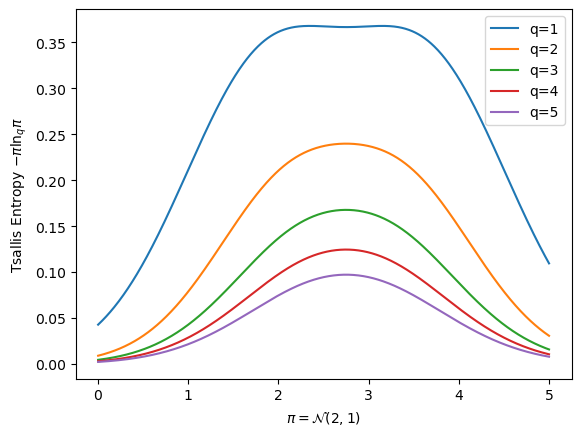

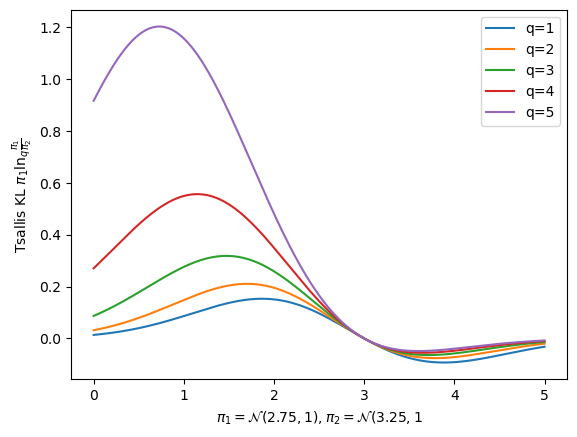

In [111]:
# Tsallis entropy, Tsallis KL of Gaussian variables
q = list(range(1, 6)) 
x = np.linspace(0.001, 5, 1000)
mu1, mu2 = 2.75, 3.25
sigma1, sigma2 = 1., 1.
g1 =  1/np.sqrt(2*np.pi*sigma1**2) * np.exp(-(x-mu1)**2/(2*sigma1**2))
g2 =  1/np.sqrt(2*np.pi*sigma2**2) * np.exp(-(x-mu2)**2/(2*sigma2**2))
ent_fig, ent_ax = plt.subplots(1, 1)
kl_fig, kl_ax = plt.subplots(1, 1)
for ent_idx in q:
    tsallis_entropy = - (g1 * q_logarithm(g1, ent_idx))
    ent_ax.plot(x, tsallis_entropy, label="q="+str(ent_idx))

    tsallis_kl = g1 * (q_logarithm(g1/g2, ent_idx))
    kl_ax.plot(x, tsallis_kl, label="q="+str(ent_idx))

ent_ax.legend()    
ent_ax.set_xlabel(r"$\pi=\mathcal{N}(2, 1)$")
ent_ax.set_ylabel(r"Tsallis Entropy $-\pi\ln_q \pi$")    

kl_ax.legend()
kl_ax.set_xlabel(r"$\pi_1=\mathcal{N}(2.75, 1), \pi_2=\mathcal{N}(3.25, 1})$")
kl_ax.set_ylabel(r"Tsallis KL $\pi_1 \ln_q \frac{\pi_1}{\pi_2}$")
plt.show()
    


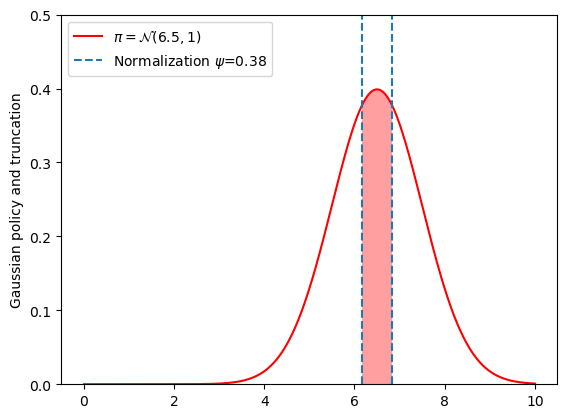

In [144]:
# sparsemax acting upon Gaussian policies
q = list(range(1, 6))
x = np.linspace(0.001, 10, 1000)
mu1, mu2 = 4.5, 6.5
sigma1, sigma2 = 1., 1.
g1 =  1/np.sqrt(2*np.pi*sigma1**2) * np.exp(-(x-mu1)**2/(2*sigma1**2))
g2 =  1/np.sqrt(2*np.pi*sigma2**2) * np.exp(-(x-mu2)**2/(2*sigma2**2))

fig, ax = plt.subplots(1, 1)
# for ent_idx in q:
policy, normalization = sparsemax_operator(g2, q=2.0)
ax.plot(x, g2, label=r"$\pi = \mathcal{N}(6.5, 1)$", color='red')
positive_idx = np.where(policy>0)[0]
ax.fill_between(x[positive_idx], np.zeros_like(positive_idx), g2[policy>0], color='red', alpha=0.375, edgecolor=None)
ax.axvline(x=x[np.where(g2 > normalization)[0][0]],  linestyle='--', label=rf"Normalization $\psi$={normalization:.2f}")
ax.axvline(x=x[np.where(g2 > normalization)[0][-1]], linestyle='--')
ax.set_ylabel("Gaussian policy and truncation")
ax.set_ylim([-0.0001, 0.5])
ax.legend()
plt.show()
    